In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import  train_test_split
import matplotlib.pyplot as plt
import pathlib
import glob as gb
import cv2
from PIL import Image as Image
from collections import Counter
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Add, Dense, Activation, Flatten, Conv2D,MaxPooling2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

In [2]:
import splitfolders
input_folder =  'E:/    /colon/Org_dataset/'
output= 'E:/    /   /colon/imgTraining/'

# Split with a ratio.
# split the dataset into two folders training and test set, set a tuple to `ratio`, i.e, `(.8, .2)`. 
# And the decomposition process will be applied to the training set.

#Train, test
splitfolders.ratio(input_folder, output=output, 
                   seed=42, ratio=(.8, .2), 
                   group_prefix=None) # default values

Copying files: 2992 files [00:04, 736.60 files/s] 


In [3]:
#get the data path
trainpath= ('E:/   /colon/imgTraining/train/')

# get the training classes
keys=os.listdir(trainpath)
values=range(len(keys))

training_classes = dict (zip(keys,values))
print('training_classes = ',training_classes)

training_classes =  {'ADI': 0, 'STR': 1, 'TUM': 2}


In [4]:
#Loading and resizing training data
new_size=227    
X_train = []
y_train = []
train_label=[]
folder_item_numbers = []

for folder in  os.listdir(trainpath ) : 
    train_label.append(folder)
    files = gb.glob(pathname= str( trainpath  + folder + '/*.tif'))
    folder_item_numbers.append(len(files))
    for file in files: 
        orignal_image = cv2.imread(file)
        image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image , (new_size,new_size))
        X_train.append(resized_image)
        y_train.append(training_classes[folder])

print('--------------------------------------------------')        
foldernames=pd.DataFrame({'Folder_name':train_label})
itemnumbers=pd.DataFrame({'Traning Image Numbers':folder_item_numbers})
informations=pd.concat([foldernames,itemnumbers],axis=1)
print(informations)
print('--------------------------------------------------')        
#check items in X_test
print("items in X_train is:       ",len(X_train) , " items") 
print("items in y_train is:       ",len(y_train) , " items") 

--------------------------------------------------
  Folder_name  Traning Image Numbers
0         ADI                   1070
1         STR                    336
2         TUM                    986
--------------------------------------------------
items in X_train is:        2392  items
items in y_train is:        2392  items


In [5]:
#shuffle data
X_train,y_train = shuffle(X_train, y_train)
# Split the training datdset into two groups
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size= 0.8)
print('Training Samples =:       ',len(x_train) ,'  and the number of labels is     ', len(y_train))
print('Validation Samples =:       ',len(x_valid) ,'  and the number of labels is     ', len(y_valid))

Training Samples =:        1913   and the number of labels is      1913
Validation Samples =:        479   and the number of labels is      479


In [ ]:
#shuffle data
x_train,y_train = shuffle(x_train, y_train)
x_valid,y_valid = shuffle(x_valid, y_valid)

#converting all TRAIN data to array
x_train = np.array(x_train) 
y_train = np.array(y_train)

x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

y_train = to_categorical(y_train,len(train_label))
y_valid = to_categorical(y_valid,len(train_label))

print("x_train shape  :" ,x_train.shape)
print("y_train shape :", y_train.shape)
print('-----------------------------------------')
print("x_valid shape  :" ,x_valid.shape)
print("y_valid shape :", y_valid.shape)


In [ ]:
#normalizing data
x_train=x_train/255.0
x_valid =x_valid/255.0

In [13]:
def get_alexnet(input_shape, num_classes):

    model = Sequential()

    # 1st Convolutional Layer: (227-11+2*0)/4 + 1 = 55
    model.add(Conv2D(kernel_size=(11,11), strides=(4,4), padding="valid", filters=96, activation='relu', 
                     input_shape=input_shape))
    # Max Pooling: (55-3+2*0)/2 + 1 = 27
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

    # 2nd Convolutional Layer: (27-5+2*2)/1 + 1 = 27
    model.add(Conv2D(kernel_size=(5,5), strides=(1,1), padding="same", filters=256, activation='relu'))
    # Max Pooling: (27-3+2*0)/2 +1 = 13
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

    # 3rd Convolutional Layer: (13-3+2*1)/1 + 1 = 13
    model.add(Conv2D(kernel_size=(3,3), strides=(1,1), padding="same", filters=384, activation='relu'))

    # 4th Convolutional Layer: (13-3+2*1) + 1 = 13
    model.add(Conv2D(kernel_size=(3,3), strides=(1,1), padding="same", filters=384, activation='relu'))

    # 5th Convolutional Layer: (13-3+2*1) + 1 = 13
    model.add(Conv2D(kernel_size=(3,3), strides=(1,1), padding="same", filters=256, activation='relu'))
    # Max Pooling: (13-3+2*0)/2 + 1 =  6
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

    # Flatten 256x6x6=9216 as one dimention vector and pass it to the 6th FC layer
    model.add(Flatten())

    # 6th layer: fully connected layer with 4096 neurons with 50% dropout.
    model.add(Dense(units=4096, activation='relu'))
    # Add Dropout
    model.add(Dropout(0.5))

    # 7th layer: fully connected layer with 4096 neurons with 50% dropout.
    model.add(Dense(units=4096, activation='relu'))
    # Add Dropout 
    model.add(Dropout(0.5))

    # 8th Layer: a fully connected layer with 1000 neurons
    model.add(Dense(units=1000, activation='relu'))
    # classification output with softmax layer
    model.add(Dense(units=num_classes, activation='softmax'))
     
    return model

In [11]:
# Provide the constants for the function. 
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227
CHANNELS = 3
NUM_CLASSES = 3

# Assign the values
INPUT_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)

# Call the AlexNet model 
#model = AlexNet(INPUT_SHAPE, NUM_CLASSES)
alexnet = get_alexnet(INPUT_SHAPE, NUM_CLASSES)

# Show the AlexNet Model 
alexnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 384)       885120    
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 384)      

In [12]:
alexnet.load_weights('alexnet_weights.h5', by_name=True)
alexnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 384)       885120    
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 384)      

In [8]:
for layer in alexnet.layers:
    layer.trainable = False
alexnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 384)      

In [9]:
for i, layer in enumerate(alexnet.layers):
    print(i, layer.name)

0 conv2d_5
1 max_pooling2d_3
2 conv2d_6
3 max_pooling2d_4
4 conv2d_7
5 conv2d_8
6 conv2d_9
7 max_pooling2d_5
8 flatten_1
9 dense_4
10 dropout_2
11 dense_5
12 dropout_3
13 dense_6
14 dense_7


In [ ]:
file_dir='E:/   /   /save_result'
filepath = os.path.join(file_dir,'decomposed_model.hdf5')
    
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True, verbose=1)
model_callbacks = [checkpoint]



In [ ]:
for layer in alexnet.layers[13:]:
        layer.trainable = True

epochs=100
batch_size=50
#sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
alexnet.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

history = alexnet.fit(x_train,y_train, validation_data= (x_valid,y_valid), epochs=epochs, batch_size=batch_size, callbacks=model_callbacks, verbose=1)

In [ ]:
#showing results and model accuracy 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
alexnet.evaluate(x_valid,y_valid)

## get features activation

In [6]:
from tensorflow.keras.models import load_model

model=load_model('E:/    /     /colon/decomposed_model.hdf5')  
alexnet_extract_features = Model(inputs=model.input, outputs=model.get_layer('dense_6').output)  


def get_feature_vector(img):
    image = cv2.resize(img, (227, 227))
    image=image.reshape(1, 227, 227, 3) #convert it to batch
    feature_vector = alexnet_extract_features.predict(image)
    return feature_vector


Dataset_path=('E:/     /   /colon/imgTraining/train/')
for folder in  os.listdir(Dataset_path ) : 
    print('extract features from class:  ',folder)
    feature=[]
    files = gb.glob(pathname= str( Dataset_path  + folder + '/*.tif'))
    for file in files: 
        image = cv2.imread(file)
        output=get_feature_vector(image)
        output=output[0]
        output=output.astype('float32')
        feature.append(output)
        
    feature=np.array(feature)
    feature.shape
    np.save(folder+'.npy', feature)

extract features from class:   ADI
extract features from class:   STR
extract features from class:   TUM


### Pca

In [29]:
f_matrix= np.load('TUM.npy')

In [30]:
from sklearn.preprocessing import StandardScaler 

sc = StandardScaler() 

# Use fit and transform method 
std_features = sc.fit_transform(f_matrix) 
 
# apply PCA technique. 
from sklearn.decomposition import PCA 
#Choosing the number of components
#pca = PCA(n_components = 45) 
pca = PCA() 
pca_features = pca.fit_transform(f_matrix) 
explained_variance = pca.explained_variance_ratio_ 
pca_features.shape

(1070, 1000)

In [ ]:
# check the cumulative explained variance ratio to select the n_components
explained_variance

## K-means cluster

In [ ]:
X=pca_features

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

In [ ]:
labels=kmeans.labels_
from collections import Counter
Counter(kmeans.labels_)

In [ ]:
# assign each image to the corresponding categories
import shutil
import glob

save_path = 'E:/  /  /colon/downstream_dataset/'
src_dir= ('E:/  /   /colon/imgTraining/train/TUM')

name=os.path.basename(os.path.normpath(src_dir))

list=[]
for i in np.unique(labels):
    if i not in list:
        c= name+'_'+str(i)
        list.append(c)

#creating subfolders
for items in list:
    path = os.path.join(save_path, items)
    os.mkdir(path)

print('list= ', list)

for img, j in zip(glob.iglob(os.path.join(src_dir, "*.tif")), labels):
    shutil.copy(img, save_path+list[j-1])

## AP cluster algorithm

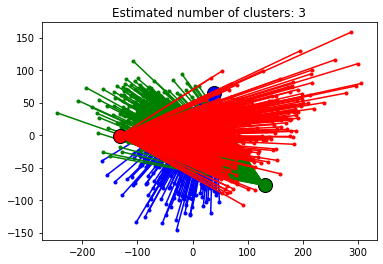

In [28]:
from sklearn.cluster import AffinityPropagation
from itertools import cycle
import sklearn.metrics as metrics
from sklearn.datasets import make_blobs
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

# Compute similarities
X=pca_features

# Compute affinity propagation cosine similarity python
dist_cosine = cosine_distances(X) # compute cosine distance matrix 
affprop = AffinityPropagation(random_state=5, affinity = 'precomputed', damping = 0.9, max_iter=5000, convergence_iter=15, preference=-50)
af = affprop.fit(dist_cosine)

cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)


# Plot result
import pylab as pl
from itertools import cycle


colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    pl.plot(X[class_members, 0], X[class_members, 1], col + '.')
    pl.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        pl.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [29]:
from collections import Counter
Counter(af.labels_)

Counter({2: 381, 1: 371, 0: 234})

In [30]:
# assign each image to the corresponding categories
import shutil
import glob

save_path = 'E:/  /  /colon/downstream_dataset/'
src_dir= ('E:/  /   /colon/imgTraining/train/TUM')

name=os.path.basename(os.path.normpath(src_dir))

list=[]
for i in np.unique(labels):
    if i not in list:
        c= name+'_'+str(i)
        list.append(c)

#creating subfolders
for items in list:
    path = os.path.join(save_path, items)
    os.mkdir(path)

print('list= ', list)

for img, j in zip(glob.iglob(os.path.join(src_dir, "*.tif")), labels):
    shutil.copy(img, save_path+list[j-1])

list=  ['TUM_0', 'TUM_1', 'TUM_2']
